
# Pandera: Beyond Pandas Data Validation 🐼✅

**Niels Bantilan**, Chief ML Engineer @ Union.ai

*SciPy 2023, July 12th 2023*

# Background

- 📜 B.A. in Biology and Dance
- 📜 M.P.H. in Sociomedical Science and Public Health Informatics
- 🤖 Chief Machine Learning Engineer @ Union.ai
- 🛩 Flytekit OSS Maintainer
- ✅ Author and Maintainer of Pandera
- 🦾 Author of UnionML
- 🛠 Make DS/ML practitioners more productive

### This is a talk about open source development 🧑🏾‍💻

# Outline 📝

- 🐣 Origins: solving a local problem
- 🐓 Evolution: solving other people's problems
- 🦩 Revolution: rewriting Pandera's internals
- 🌅 What's next?

### Where's the Code?

🖼 **Slides**: https://pandera-dev.github.io/pandera-presentations/slides/20230712_scipy_beyond_pandas.slides.html

📓 **Notebook**: https://github.com/pandera-dev/pandera-presentations/blob/master/notebooks/20230712_scipy_beyond_pandas.ipynb

# 🐣 Origins

In [1]:
import os
import warnings
import pyspark

from IPython.display import display, Markdown

warnings.simplefilter("ignore")
pyspark.SparkContext().setLogLevel("OFF")
os.environ["MODIN_ENGINE"] = "ray"

## 🤷‍♂️ Why Should I Validate Data?

## What's a `DataFrame`?

In [2]:
import uuid

import numpy as np
import pandas as pd

dataframe = pd.DataFrame({
    "person_id": [str(uuid.uuid4())[:7] for _ in range(6)],
    "hours_worked": [38.5, 41.25, "35.0", 27.75, 22.25, -20.5],
    "wage_per_hour": [15.1, 15, 21.30, 17.5, 19.50, 25.50],
}).set_index("person_id")

df = dataframe

In [3]:
dataframe.head()

,hours_worked,wage_per_hour
person_id,,
1ac0c42,38.5,15.1
edda497,41.25,15.0
e8c6fb7,35.0,21.3
1332472,27.75,17.5
beb478b,22.25,19.5


## What's Data Validation?

Data validation is the act of _falsifying_ data against explicit assumptions
for some downstream purpose, like analysis, modeling, and visualization.

> "All swans are white"

In [4]:
%%html
<p>
    <a href="https://commons.wikimedia.org/wiki/File:Black_Swans.jpg#/media/File:Black_Swans.jpg">
    <img src="https://upload.wikimedia.org/wikipedia/commons/6/60/Black_Swans.jpg" alt="Pair of black swans swimming" height="275" width="275"
     style="display: block; margin-left: auto; margin-right: auto;"/>
    </a>
    <p style="font-size: x-small; text-align: center;">
    <a href="http://creativecommons.org/licenses/by-sa/3.0/" title="Creative Commons Attribution-Share Alike 3.0">CC BY-SA 3.0</a>,
    <a href="https://commons.wikimedia.org/w/index.php?curid=1243220">Link</a>
    </p>
</p>

## Why Do I Need it?

#### 🐞 It can be difficult to reason about and debug data processing pipelines.

#### ⚠️ It's critical to ensuring data quality in many contexts especially when the end product informs business decisions, supports scientific findings, or generates predictions in a production setting.

## Everyone has a personal relationship with their dataframes

### Story Time 📖

##### Imagine that you're a data scientist maintaining an existing data processing pipeline 👩‍💻👨‍💻...

In [5]:
def process_data(df):
    return df.assign(weekly_income=lambda x: x.hours_worked * x.wage_per_hour)

try:
    process_data(dataframe)
except TypeError as exc:
    print(exc)

can't multiply sequence by non-int of type 'float'


### One day, you encounter an error log trail and decide to follow it...

```python
/usr/local/miniconda3/envs/pandera-presentations/lib/python3.7/site-packages/pandas/core/ops/__init__.py in masked_arith_op(x, y, op)
    445         if mask.any():
    446             with np.errstate(all="ignore"):
--> 447                 result[mask] = op(xrav[mask], com.values_from_object(yrav[mask]))
    448 
    449     else:

TypeError: can't multiply sequence by non-int of type 'float'
```

### And you find yourself at the top of a function...

In [6]:
def process_data(df):
    ...

### You look around, and see some hints of what had happened...

In [7]:
def process_data(df):
    return df.assign(weekly_income=lambda x: x.hours_worked * x.wage_per_hour)

### You sort of know what's going on, but you want to take a closer look!

In [8]:
def process_data(df):
    import pdb; pdb.set_trace()  # <- insert breakpoint
    return df.assign(weekly_income=lambda x: x.hours_worked * x.wage_per_hour)

### And you find some funny business going on...

In [9]:
print(df)

          hours_worked  wage_per_hour
person_id                            
1ac0c42           38.5           15.1
edda497          41.25           15.0
e8c6fb7           35.0           21.3
1332472          27.75           17.5
beb478b          22.25           19.5
40e25f2          -20.5           25.5


In [10]:
df.dtypes

hours_worked      object
wage_per_hour    float64
dtype: object

In [11]:
df.hours_worked.map(type)

person_id
1ac0c42    <class 'float'>
edda497    <class 'float'>
e8c6fb7      <class 'str'>
1332472    <class 'float'>
beb478b    <class 'float'>
40e25f2    <class 'float'>
Name: hours_worked, dtype: object

### You squash the bug and add documentation for the next weary traveler who happens upon this code.

In [12]:
def process_data(df):
    return (
        df
        # make sure columns are floats
        .astype({"hours_worked": float, "wage_per_hour": float})
        # replace negative values with nans
        .assign(hours_worked=lambda x: x.hours_worked.where(x.hours_worked >= 0, np.nan))
        # compute weekly income
        .assign(weekly_income=lambda x: x.hours_worked * x.wage_per_hour)
    )

In [13]:
process_data(df)

,hours_worked,wage_per_hour,weekly_income
person_id,,,
1ac0c42,38.50,15.1,581.350
edda497,41.25,15.0,618.750
e8c6fb7,35.00,21.3,745.500
1332472,27.75,17.5,485.625
beb478b,22.25,19.5,433.875
40e25f2,NaN,25.5,NaN


### ⏱ A few months later...

### You find yourself at a familiar function, but it looks a little different from when you left it...

In [14]:
# This needs to be here, but skipped for story-telling effect in the slides
import pandera as pa
from pandera.typing import DataFrame

class RawData(pa.DataFrameModel):
    hours_worked: float = pa.Field(coerce=True, nullable=True)
    wage_per_hour: float = pa.Field(coerce=True, nullable=True)

class ProcessedData(RawData):
    hours_worked: float = pa.Field(ge=0, coerce=True, nullable=True)
    weekly_income: float = pa.Field(nullable=True)

In [15]:
@pa.check_types
def process_data(df: DataFrame[RawData]) -> DataFrame[ProcessedData]:
    return (
        # replace negative values with nans
        df.assign(hours_worked=lambda x: x.hours_worked.where(x.hours_worked >= 0, np.nan))
        # compute weekly income
        .assign(weekly_income=lambda x: x.hours_worked * x.wage_per_hour)
    )

### You look above and see what `RawData` and `ProcessedData` are, finding a `NOTE` that a fellow traveler has left for you.

In [16]:
import pandera as pa

# NOTE: this is what's supposed to be in `df` going into `process_data`
class RawData(pa.SchemaModel):
    hours_worked: float = pa.Field(coerce=True, nullable=True)
    wage_per_hour: float = pa.Field(coerce=True, nullable=True)


# ... and this is what `process_data` is supposed to return.
class ProcessedData(RawData):
    hours_worked: float = pa.Field(ge=0, coerce=True, nullable=True)
    weekly_income: float = pa.Field(nullable=True)


@pa.check_types
def process_data(df: DataFrame[RawData]) -> DataFrame[ProcessedData]:
    ...

## Moral of the Story

> ##### The better you can reason about the contents of a dataframe, the faster you can debug.

> ##### The faster you can debug, the sooner you can focus on downstream tasks that you care about.

> ##### By validating data through explicit contracts, you also create data documentation *and* a simple, stateless data shift detector.

## Pandera Design Principles

![pandera design principles](../static/pandera-design-principles.png)

## Pandera Programming Model

# 🐓 Evolution

## Major Events

## Expanding Scope

# 🦩 Revolution

## Rewriting Pandera Internals

## Retrospective

## Updated Principles

# 🤔 What's Data Testing

### And How Can I Put it Into Practice?

> **Data validation:** The act of falsifying data against explicit assumptions for some downstream purpose, like
> analysis, modeling, and visualization.

> **Data Testing:** Validating not only real data, but also the functions that produce them.


# In the Real World 🌍

#### Validate real data in production


# In the Test Suite 🧪

#### Validate functions that produce data, given some test cases

## Data Testing in Practice

#### Data testing is an iterative process of:

- Building statistical domain knowledge about the data at hand with respect to the stated goal.
- Implementing data transforms and defining schemas/tests in parallel.
- Verifying that the output of the data transform is what you expected.

# ✅ Pandera Quickstart

### Create statistical types for your DataFrames

<img src="https://raw.githubusercontent.com/pandera-dev/pandera/master/docs/source/_static/pandera-logo.png" width="125px" style="margin: 0;"/>

<h2 style="margin-top: 0;">Pandera</h2>

#### An expressive and light-weight statistical typing tool for dataframe-like containers

- Check the types and properties of dataframes
- Easily integrate with existing data pipelines via function decorators
- Synthesize data from schema objects for property-based testing

#### Object-based API

Defining a schema looks and feels like defining a pandas dataframe

In [17]:
import pandera as pa

clean_data_schema = pa.DataFrameSchema(
    columns={
        "continuous": pa.Column(float, pa.Check.ge(0), nullable=True),
        "categorical": pa.Column(str, pa.Check.isin(["A", "B", "C"]), nullable=True),
    },
    coerce=True,
)

#### Class-based API

Define complex types with modern Python, inspired by [pydantic](https://pydantic-docs.helpmanual.io/) and `dataclasses`

In [18]:
from pandera.typing import DataFrame, Series

class CleanData(pa.SchemaModel):
    continuous: Series[float] = pa.Field(ge=0, nullable=True)
    categorical: Series[str] = pa.Field(isin=["A", "B", "C"], nullable=True)

    class Config:
        coerce = True

Pandera comes in two flavors

#### Pandera Raises Informative Errors

Know Exactly What Went Wrong with Your Data

In [19]:
raw_data = pd.DataFrame({
    "continuous": ["-1.1", "4.0", "10.25", "-0.1", "5.2"],
    "categorical": ["A", "B", "C", "Z", "X"],
})

try:
    CleanData.validate(raw_data, lazy=True)
except pa.errors.SchemaErrors as exc:
    display(exc.failure_cases)

,schema_context,column,check,check_number,failure_case,index
0,Column,continuous,greater_than_or_equal_to(0),0,-1.1,0
1,Column,continuous,greater_than_or_equal_to(0),0,-0.1,3
2,Column,categorical,"isin(['A', 'B', 'C'])",0,Z,3
3,Column,categorical,"isin(['A', 'B', 'C'])",0,X,4


### Pandera Supports Schema Transformations/Inheritence

#### Object-based API

Dynamically transform schema objects on the fly

In [20]:
raw_data_schema = pa.DataFrameSchema(
    columns={
        "continuous": pa.Column(float),
        "categorical": pa.Column(str),
    },
    coerce=True,
)

clean_data_schema.update_columns({
    "continuous": {"nullable": True},
    "categorical": {"checks": pa.Check.isin(["A", "B", "C"]), "nullable": True},
});

#### Class-based API

Inherit from `pandera.SchemaModel` to Define Type Hierarchies

In [21]:
class RawData(pa.SchemaModel):
    continuous: Series[float]
    categorical: Series[str]

    class Config:
        coerce = True

class CleanData(RawData):
    continuous = pa.Field(ge=0, nullable=True)
    categorical = pa.Field(isin=["A", "B", "C"], nullable=True);

### Integrate Seamlessly with your Pipeline

Use decorators to add IO checkpoints to the critical functions in your pipeline

In [22]:
@pa.check_types
def fn(raw_data: DataFrame[RawData]) -> DataFrame[CleanData]:
    return raw_data.assign(
        continuous=lambda df: df["continuous"].where(lambda x: x > 0, np.nan),
        categorical=lambda df: df["categorical"].where(lambda x: x.isin(["A", "B", "C"]), np.nan),
    )


fn(raw_data)

,continuous,categorical
0,NaN,A
1,4.00,B
2,10.25,C
3,NaN,NaN
4,5.20,NaN


### Generative Schemas

Schemas that synthesize valid data under its constraints

In [23]:
CleanData.example(size=5)

,continuous,categorical
0,NaN,C
1,4.940656e-324,A
2,2.847778e+14,A
3,NaN,NaN
4,NaN,NaN


**Data Testing:** Test the functions that produce clean data

In [24]:
from hypothesis import given


@given(RawData.strategy(size=5))
def test_fn(raw_data):
    fn(raw_data)


def run_test_suite():
    test_fn()
    print("tests passed ✅")


run_test_suite()

tests passed ✅


## Scaling Pandera with Pandas' Friends 🐼🌈✨

Pandera supports `dask`, `modin`, and `pyspark.pandas` dataframes to scale
data validation to big data.

In [25]:
display(raw_data)

,continuous,categorical
0,-1.1,A
1,4.0,B
2,10.25,C
3,-0.1,Z
4,5.2,X


### Apply a single schema to a suite of dataframe-like objects

#### `dask`

In [26]:
import dask.dataframe as dd

dask_dataframe = dd.from_pandas(raw_data, npartitions=1)

try:
    CleanData(dask_dataframe, lazy=True).compute()
except pa.errors.SchemaErrors as exc:
    display(exc.failure_cases.sort_index())

,schema_context,column,check,check_number,failure_case,index
0,Column,continuous,greater_than_or_equal_to(0),0,-1.1,0
1,Column,continuous,greater_than_or_equal_to(0),0,-0.1,3
2,Column,categorical,"isin(['A', 'B', 'C'])",0,Z,3
3,Column,categorical,"isin(['A', 'B', 'C'])",0,X,4


### Apply a single schema to a suite of dataframe-like objects

#### `modin`

In [30]:
import modin.pandas as mpd

modin_dataframe = mpd.DataFrame(raw_data)

try:
    CleanData(modin_dataframe, lazy=True)
except pa.errors.SchemaErrors as exc:
    display(exc.failure_cases.sort_index())

,schema_context,column,check,check_number,failure_case,index
0,Column,continuous,greater_than_or_equal_to(0),0,-1.1,0
1,Column,continuous,greater_than_or_equal_to(0),0,-0.1,3
2,Column,categorical,"isin(['A', 'B', 'C'])",0,Z,3
3,Column,categorical,"isin(['A', 'B', 'C'])",0,X,4


### Apply a single schema to a suite of dataframe-like objects

#### `pyspark.pandas`

In [28]:
import pyspark.pandas as ps

pyspark_pd_dataframe = ps.DataFrame()

try:
    CleanData(pyspark_pd_dataframe, lazy=True)
except pa.errors.SchemaErrors as exc:
    display(exc.failure_cases)

,schema_context,column,check,check_number,failure_case,index
0,DataFrameSchema,None,column_in_dataframe,None,continuous,None
1,DataFrameSchema,None,column_in_dataframe,None,categorical,None


### Meta Comment

##### This presentation notebook is validated by pandera 🤯

![mindblown](https://media.giphy.com/media/xT0xeJpnrWC4XWblEk/giphy-downsized-large.gif)

## ⌨️ Statistical Typing

#### Type systems help programmers reason about and write more robust code

In [29]:
from typing import Union

Number = Union[int, float]

def add_and_double(x: Number, y: Number) -> Number:
    ...

#### Can you predict the outcome of these function calls?

In [30]:
add_and_double(5, 2)
add_and_double(5, "hello")
add_and_double(11.5, -1.5)

#### Similarly...

In [31]:
import pandera as pa
from pandera.typing import DataFrame, Series

class Inputs(pa.SchemaModel):
    x: Series[int]
    y: Series[int]

    class Config:
        coerce = True


class Outputs(Inputs):
    z: Series[int]
        
    @pa.dataframe_check
    def custom_check(cls, df: DataFrame) -> Series:
        return df["z"] == (df["x"] + df["y"]) * 2
    
    
@pa.check_types
def add_and_double(raw_data: DataFrame[Inputs]) -> DataFrame[Outputs]:
    ...

### 🤔 What's Statistical Typing?

> **Statistical typing** extends primitive data types with additional semantics
> about the _properties held by a collection of data points_.

#### Consider a single data point

In [32]:
data_point = {"square_footage": 700, "nbedrooms": 1, "price": 500_000}

- Primitive datatypes
- Value range
- Allowable values
- Regex string match
- Nullability

#### Now consider a collection data point

In [33]:
data_points = [
    {"square_footage": 700, "nbedrooms": 1, "price": 500_000},
    {"square_footage": 1000, "nbedrooms": 2, "price": 750_000},
    {"square_footage": 3000, "nbedrooms": 4, "price": 1_000_000},
    ...
]

- Apply atomic checks at scale
- Uniqueness
- Monotonicity
- Mean, median, standard deviation
- Fractional checks, e.g. 90% of data points are not null

### Pandera is a Statistical Type System Geared Towards Data Science

Statistical types are defined with multiple layers 🧅

> **primitive data types**: `int`, `float`, `bool`, `str`, etc.

> **deterministic properties**: domain of possible values, e.g. `x >= 0`

> **probabilistic properties**: distributions that apply to the variable and their sufficient statistics, e.g. `mean`,
  `standard deviation`

# 📊 Example 1: Validate your Data analysis

## Dataset: California Housing

A dataset containing ~20,000 samples where each row is a California district and
each column is an aggregate statistic about that district.

In [34]:
from sklearn.datasets import fetch_california_housing

housing_data = fetch_california_housing(as_frame=True).frame
housing_data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


#### With a cursory glance at the data...

In [35]:
housing_data.head(5)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


#### We can start defining a basic schema

In [36]:
class HousingData(pa.SchemaModel):

    # features
    MedInc: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100})
    HouseAge: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100})
    AveRooms: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 1_000})
    AveBedrms: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100})
    Population: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100_000})
    AveOccup: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 10_000})
    Latitude: Series[float] = pa.Field(in_range={"min_value": -90, "max_value": 90})
    Longitude: Series[float] = pa.Field(in_range={"min_value": -180, "max_value": 180})

    # target variable! 🎯
    MedHouseVal: Series[float] = pa.Field(in_range={"min_value": 0, "max_value": 100})

    class Config:
        coerce = True


@pa.check_types
def read_data() -> DataFrame[HousingData]:
    return fetch_california_housing(as_frame=True).frame


housing_data = read_data()
print("validation passed ✅")

validation passed ✅


### Analysis Pipeline

Hypothesis: Median income is positively correlated with Median House Value

Pearson correlation coefficient = 0.688075

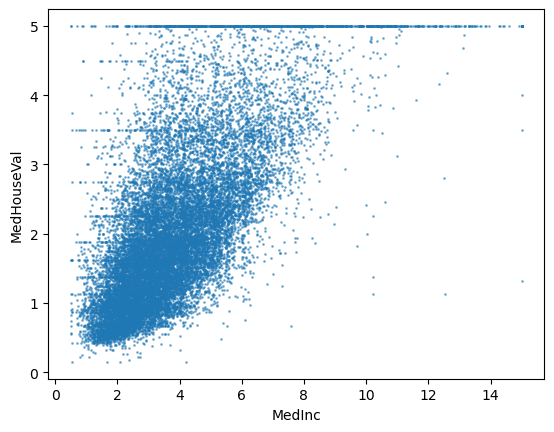

In [37]:
def analyze_data(housing_data, var1, var2):
    correlation_coef = housing_data[[var1, var2]].corr().at[var1, var2]
    display(Markdown(f"Pearson correlation coefficient = {correlation_coef:0.06f}"))
    housing_data.plot.scatter(var1, var2, s=1, alpha=0.5)

analyze_data(housing_data, "MedInc", "MedHouseVal")

#### Bake in statistical hypothesis testing into your pipeline

Easily create re-usable custom checks

In [38]:
from scipy.stats import pearsonr
import pandera.extensions as extensions

@extensions.register_check_method(
    statistics=["var1", "var2", "alpha"],
    supported_types=[pd.DataFrame]
)
def is_positively_correlated(
    df: pd.DataFrame,
    *,
    var1: str,
    var2: str,
    alpha: float = 0.01,
):
    """Perform Pearson correlation hypothesis test."""

    r, pvalue = pearsonr(df[var1], df[var2])
    passed = r > 0 and pvalue <= alpha

    pretty_pvalue = np.format_float_scientific(pvalue)
    if passed:
        print(f"✅ {var1} is positively correlated with {var2} with r = {r:0.04f}; pvalue = {pretty_pvalue}")
    else:
        print(f"❌ {var1} not correlated with {var2} with with r = {r:0.04f}; pvalue = {pretty_pvalue}")

    return passed

#### Dynamically create schemas as statistical hypothesis validators

✅ MedInc is positively correlated with MedHouseVal with r = 0.6881; pvalue = 0.e+00


Pearson correlation coefficient = 0.688075

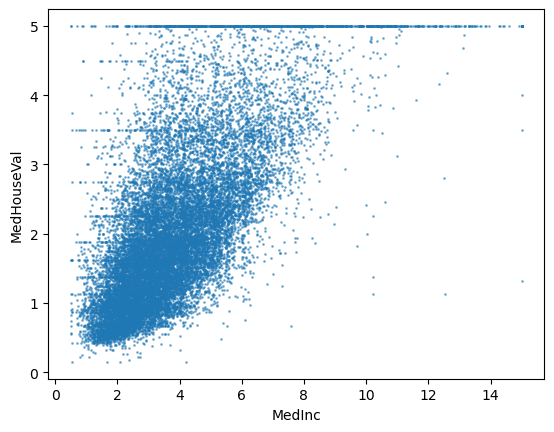

In [39]:
def analyze_data(housing_data, var1: str, var2: str):

    class HousingDataHypothesis(HousingData):
        class Config:
            coerce = True
            is_positively_correlated = {
                "var1": var1,
                "var2": var2,
                "alpha": 0.01,
            }

    housing_data = HousingDataHypothesis.validate(housing_data)
    correlation_coef = housing_data[[var1, var2]].corr().at[var1, var2]
    display(Markdown(f"Pearson correlation coefficient = {correlation_coef:0.06f}"))
    housing_data.plot.scatter(var1, var2, s=1, alpha=0.5)


analyze_data(housing_data, "MedInc", "MedHouseVal")

#### The Analysis Pipeline

Every time this runs, pandera makes sure all the assumptions encoded in the schemas
hold true.

✅ MedInc is positively correlated with MedHouseVal with r = 0.6881; pvalue = 0.e+00


Pearson correlation coefficient = 0.688075

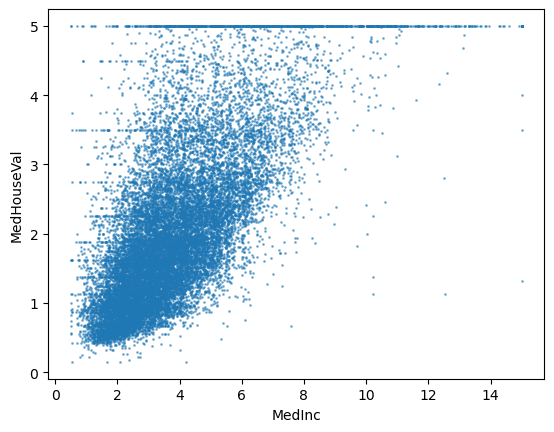

In [40]:
def run_analysis_pipeline(var1: str, var2: str):
    data = read_data()
    analyze_data(data, var1, var2)


run_analysis_pipeline("MedInc", "MedHouseVal")

# 🤖 Example 2: Validate your Machine Learning Pipeline

### Prediction Task:

From all the features, predict the median house value target `MedHouseVal`.

In [41]:
from typing import Tuple

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split


# ⚠️ This is the most critical part to check
@pa.check_types
def split_data(
    data: DataFrame[HousingData],
    test_size: float = 0.2,
) -> Tuple[DataFrame[HousingData], DataFrame[HousingData]]:
    return train_test_split(data, test_size=test_size)


# 👉 Notice that I don't use @pa.check_types here
def parse_data(data: DataFrame[HousingData], target: str) -> Tuple[DataFrame[HousingData], pd.Series]:
    features = [column for column in data if column != target]
    return data[features], data[target]


# 🔽 At this point onward the type annotations are for type linters like mypy
def train(features: pd.DataFrame, target: pd.Series) -> LinearRegression:
    model = LinearRegression()
    return model.fit(features, target)


def evaluate(model: LinearRegression, features: pd.DataFrame, target: pd.Series) -> float:
    prediction = model.predict(features)
    return r2_score(target, prediction)

#### Running a validated training pipeline

In [42]:
def run_training_pipeline(data: pd.DataFrame, target: str):
    train_data, test_data = split_data(data)
    train_features, train_target = parse_data(train_data, target)

    # train a model
    model = train(train_features, train_target)

    # evaluate
    train_r2 = evaluate(model, train_features, train_target)
    test_r2 = evaluate(model, *parse_data(test_data, target))

    return model, train_r2, test_r2


model, train_r2, test_r2 = run_training_pipeline(read_data(), "MedHouseVal")
print(f"🏋️‍♂️ Train R^2 score: {train_r2:0.6f}")
print(f"📝 Test R^2 score: {test_r2:0.6f}")
model

🏋️‍♂️ Train R^2 score: 0.608329
📝 Test R^2 score: 0.597706


LinearRegression()

#### Unit testing a training pipeline

Synthesize mock training data so that you don't have to hand-craft dataframes 🤯

In [43]:
from hypothesis import settings

prediction_schema = pa.SeriesSchema(
    float,
    # in-line custom checks
    pa.Check(lambda s: (s >= 0).mean() > 0.05, name="predictions are mostly positive"),
    nullable=False,
)


@given(HousingData.strategy(size=20))
@settings(max_examples=3)
def test_run_training_pipeline(data):
    target = "MedHouseVal"
    model, *_ = run_training_pipeline(data, target)
    features, _ = parse_data(data, target)
    predictions = pd.Series(model.predict(features))

    # validate predictions
    prediction_schema(predictions)


def run_test_suite():
    test_run_training_pipeline()
    print("✅ training pipeline test suite passed!")


run_test_suite()

✅ training pipeline test suite passed!


# ⭐️ Conclusion: How can I start using Pandera in my work?

### Incrementally adopt `pandera` into your workflow

> 🧠 → 📝 Encode the domain knowledge that you build up during the development and exploration process into schemas.

> 🥾✨ If you're in a hurry, use [`pandera.infer_schema`](https://pandera.readthedocs.io/en/stable/schema_inference.html)
> to bootstrap a schema and refine it over time.

> ❗️ Identify the critical functions in your data processing pipeline and add `@pa.check_types` decorators as
checkpoints.

> 🔩 Codify data quality checks that are specific to your problem domain by creating reusable custom validation rules
> via `@pandera.extensions.register_check_method`.

> 🔄 Reuse schemas for runtime validation or test-time validation.

> 🤩 Be more confident in the correctness of your analysis/model with programmatically enforced, self-documenting code.

## 🛣 Future Roadmap

- 📏 **Extensibility:** getting support for other schema formats and data container objects e.g.
  `xarray`, `jsonschema`, `cudf`, `pyarrow`, and an extension API for arbitrary data containers.
- 💻 **UX:** better error-reporting, more built-in checks, statistical hypothesis checks, conditional validation, and more!
- 🤝 **Interoperability:** tighter integrations with the python ecosystem, e.g. `fastapi`, `pydantic`, `pytest`

# Join the Community!

![badge](https://img.shields.io/github/stars/pandera-dev/pandera?style=social)
[![badge](https://img.shields.io/pypi/pyversions/pandera.svg)](https://pypi.python.org/pypi/pandera/)
[![badge](https://img.shields.io/pypi/v/pandera.svg)](https://pypi.org/project/pandera/)
![badge](https://img.shields.io/github/contributors/pandera-dev/pandera)
[![badge](https://pepy.tech/badge/pandera)](https://pepy.tech/project/pandera)
[![badge](https://pepy.tech/badge/pandera/month)](https://pepy.tech/project/pandera)
[![badge](https://img.shields.io/badge/discord-chat-purple?color=%235765F2&label=discord&logo=discord)](https://discord.gg/vyanhWuaKB)


- **Twitter**: [@cosmicbboy](https://twitter.com/cosmicBboy)
- **Discord**: https://discord.gg/vyanhWuaKB
- **Email**: [niels@union.ai](mailto:niels@union.ai)
- **Repo**: https://github.com/unionai-oss/pandera
- **Docs**: https://pandera.readthedocs.io
- **Contributing Guide**: https://pandera.readthedocs.io/en/stable/CONTRIBUTING.html
- **Become a Sponsor**: https://github.com/sponsors/cosmicBboy